# 개요  

이미 종료된 Competition이지만 데이콘에서 주최했던, "제주도 퇴근시간 버스 승하차 인원 예측"이라는 프로젝트를 사내 스터디겸 진행해보았다.  
개인적으로 모델링에 집중해서 머신러닝 알고리즘, 페이퍼 리뷰에 초점을 맞추려고 했지만, 결론적으로 시간... 할애를 많이 못했다ㅠㅠ
아쉽지만 정리해 놓고 기회될때 정확도 개선하기로!  
  
  
프로젝트관련 설명과 데이터셋 구성, 스키마 등의 정보는 [여기](https://github.com/yganalyst/dacon_project1)에 정리해 두었다.  

# EDA  

In [22]:
import pandas as pd 
import numpy as np
import os 
import geopandas as gpd
import sys
from shapely.geometry import *
from shapely.ops import *
from fiona.crs import from_string
import warnings
warnings.filterwarnings(action='ignore')

epsg4326 = from_string("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
matplotlib.rc('font', family = font_name)
import folium

In [15]:
os.chdir(r"D:\Python\dacon_bus_inout\data")
print("path: "+os.getcwd())
print(os.listdir())

path: D:\Python\dacon_bus_inout\data
['bus_bts.csv', 'LSMD_ADM_SECT_UMD_50.dbf', 'LSMD_ADM_SECT_UMD_50.prj', 'LSMD_ADM_SECT_UMD_50.shp', 'LSMD_ADM_SECT_UMD_50.shx', 'LSMD_ADM_SECT_UMD_제주.zip', 'submission_sample.csv', 'test.csv', 'train.csv', 'weather.csv', '제주도_건물정보1.csv', '제주도_건물정보2.csv', '행정_법정동 중심좌표.xlsx']


In [16]:
# dir_ = ""
train = pd.read_csv("train.csv", dtype=str, encoding='utf-8')
test = pd.read_csv("test.csv", dtype=str, encoding='utf-8')
bus_bts = pd.read_csv("bus_bts.csv", dtype=str, encoding='utf-8')
bjd_wgd = pd.read_excel("행정_법정동 중심좌표.xlsx", dtype= str, sheet_name="합본 DB")
sub = pd.read_csv("submission_sample.csv", dtype=str, encoding='utf-8')
print("train :", len(train))
print("test :", len(test))
print("bus_bts :", len(bus_bts))
print("submission_sample :", len(sub))

train : 415423
test : 228170
bus_bts : 2409414
submission_sample : 228170


# 1. 데이터 셋  기본정보  

**train set**

In [13]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508000000001,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.481809999999996,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.255790000000005,126.4126,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


**test set**

In [17]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508000000001,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.481809999999996,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**bus_bts(버스카드 별 승하차 정보)**  

In [18]:
bus_bts.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1010010127894129.0,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1010010101730356.0,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1019160032727943.0,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1019150001770890.0,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1010010097237127.0,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


## 1-1. 기초통계  

In [36]:
round(train.describe(),3)

,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
count,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000,415423.000
mean,0.306,0.830,0.815,0.642,0.600,0.579,0.113,0.345,0.516,0.431,0.408,0.403,1.242
std,1.110,2.255,2.318,1.960,1.886,1.942,0.598,1.279,1.659,1.485,1.413,1.446,4.722
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
max,85.000,94.000,136.000,78.000,124.000,99.000,45.000,66.000,59.000,65.000,52.000,81.000,272.000


In [37]:
print("시간대별 승차인원 1명 이하 비율")
print(pd.DataFrame({'train':round((train[col_t] <= 1).sum() / len(train) * 100),
                  'test':round((test[col_t] <= 1).sum() / len(test) * 100)}))

시간대별 승차인원 1명 이하 비율
               train  test
6~7_ride        94.0  94.0
7~8_ride        84.0  85.0
8~9_ride        84.0  84.0
9~10_ride       87.0  87.0
10~11_ride      88.0  87.0
11~12_ride      89.0  88.0
6~7_takeoff     98.0  98.0
7~8_takeoff     94.0  94.0
8~9_takeoff     90.0  90.0
9~10_takeoff    92.0  91.0
10~11_takeoff   92.0  91.0
11~12_takeoff   92.0  91.0


- 기본적으로 시간대별 승하차인원과 종속변수인 저녁시간 승차인원(18~20_ride)도 0과 1의 값을 가지는 비율이 80_90%를 차지한다.    
- 회귀문제에서는 이러한 불균형 데이터에 대해 어떤 조치를 취할 수 있을 지 고민해 봐야한다.  

## 1-2. 결측값 확인  

In [19]:
pd.DataFrame({'train':train.isnull().sum(),
              'test':test.isnull().sum()}).fillna('')

,train,test
10~11_ride,0,0
10~11_takeoff,0,0
11~12_ride,0,0
11~12_takeoff,0,0
18~20_ride,0,
6~7_ride,0,0
6~7_takeoff,0,0
7~8_ride,0,0
7~8_takeoff,0,0
8~9_ride,0,0


In [20]:
bus_bts.isnull().sum()

user_card_id                0
bus_route_id                0
vhc_id                      0
geton_date                  0
geton_time                  0
geton_station_code          0
geton_station_name         49
getoff_date            895736
getoff_time            895736
getoff_station_code    895736
getoff_station_name    895775
user_category               0
user_count                  0
dtype: int64

- 결측값은 bus_bts 데이터에만 존재 : 하차태그 안한 경우(895736, 약 37%), 정류장이름 없음(49)  

## 1-3. 컬럼별 타입변경  

In [24]:
col_t = [str(j)+"~"+ str(j+1) + "_" + str(i) for i in ("ride","takeoff") for j in range(6,12)]
train['date'] = pd.to_datetime(train['date'])
train[col_t + ['18~20_ride']] = train[col_t + ['18~20_ride']].astype(float)
test['date'] = pd.to_datetime(test['date'])
test[col_t] = test[col_t].astype(float)
bus_bts['geton_datetime'] = pd.to_datetime(bus_bts['geton_date'] + ' ' + bus_bts['geton_time'])
bus_bts['getoff_datetime'] = pd.to_datetime(bus_bts['getoff_date'] + ' ' + bus_bts['getoff_time'])
bus_bts['user_category'] = bus_bts['user_category'].astype(int)
bus_bts['user_count'] = bus_bts['user_count'].astype(float)

## 1-4. 히스토그램 - 분포 탐색    

**일별, 시간대별(승차), 승차인원 수**  

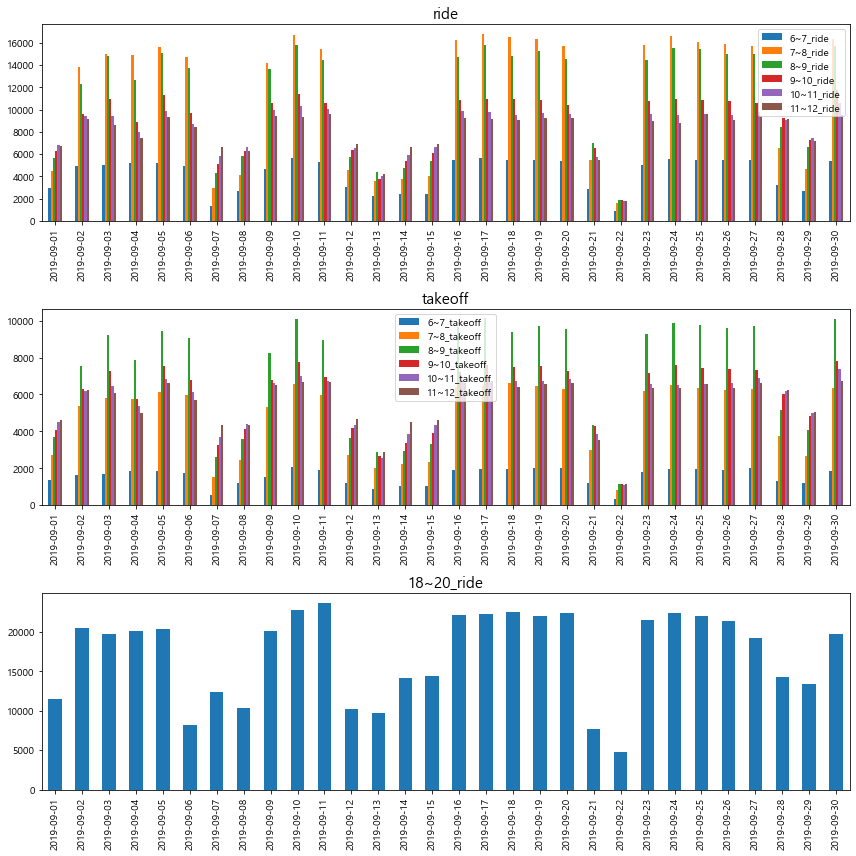

In [38]:
date_sum_ = train.groupby(['date'])[col_t + ['18~20_ride']].sum()
date_sum_.index = date_sum_.index.date

plt.figure(figsize=(12,12))
ax=plt.subplot(3,1,1)
date_sum_[date_sum_.columns[:6]].plot(kind='bar', ax=ax)
plt.title("ride", fontsize=15)
ax=plt.subplot(3,1,2)
date_sum_[date_sum_.columns[6:-1]].plot(kind='bar', ax=ax)
plt.title("takeoff", fontsize=15)
ax=plt.subplot(3,1,3)
date_sum_[date_sum_.columns[-1]].plot(kind='bar', ax=ax)
plt.title("18~20_ride", fontsize=15)

plt.tight_layout()
plt.show()

- 평일과 주말에 버스 이용율 차이에 대한 패턴이 보인다.  
- 요일 변수(category) 또는 평일여부(dummy) 파생변수에 대한 고려가 필요해보임.  

**요일, 공휴일여부, 주말여부 변수생성**  

In [39]:
def get_dayattr(df):
    # 0(Monday) ~ 6(Sunday)
    df['dayofweek'] = df['date'].dt.dayofweek
    # 추석, 한글날, 개천절
    holiday=['2019-09-12', '2019-09-13', '2019-09-14','2019-10-03','2019-10-09']
    df['weekends'] = np.where(df['dayofweek'] >= 5, 1,0) # 주말여부
    df['holiday'] = np.where(df['date'].isin(holiday), 1,0) # 공휴일여부
    return df
train = get_dayattr(train)

**주요 정류장에 대한 평일,쉬는날(평일X)의 버스이용인원 차이 탐색**  

In [41]:
def dayofweek_print_plot(train, idx_min=0,idx_max=15, sorting_col = 'total_ride'):
    # 평일
    train_1 = train[(train['weekends']==0) & (train['holiday']==0)].groupby(['station_code','station_name'])[col_t].sum().reset_index()
    train_1['total_ride'] = train_1[col_t[:6]].sum(axis=1)
    train_1['total_getoff'] = train_1[col_t[6:]].sum(axis=1)
    train_1 = train_1.sort_values(by=sorting_col,ascending=False).reset_index()
    # 쉬는날
    train_2 = train[(train['weekends']==1) | (train['holiday']==1)].groupby(['station_code','station_name'])[col_t].sum().reset_index()
    train_2['total_ride'] = train_2[col_t[:6]].sum(axis=1)
    train_2['total_getoff'] = train_2[col_t[6:]].sum(axis=1)
    # 평일 기준 Top 15 비교
    ls_ = train_1.iloc[idx_min:idx_max]['station_code'].unique().tolist()
    train_1_1 = train_1.iloc[idx_min:idx_max].set_index(['station_code','station_name'])
    train_2_2 = train_2[train_2['station_code'].isin(ls_)].set_index(['station_code','station_name']).reindex(train_1_1.index)
    plt.figure(figsize=(12,12))
    ax = plt.subplot(2,1,1)
    plt.title("평일")
    train_1_1[['total_ride','total_getoff']].plot(kind='bar', ax=ax)
    plt.grid()
    ax = plt.subplot(2,1,2)
    plt.title("쉬는날")
    train_2_2[['total_ride','total_getoff']].plot(kind='bar', ax=ax)
    plt.tight_layout()
    plt.grid()
    plt.show()

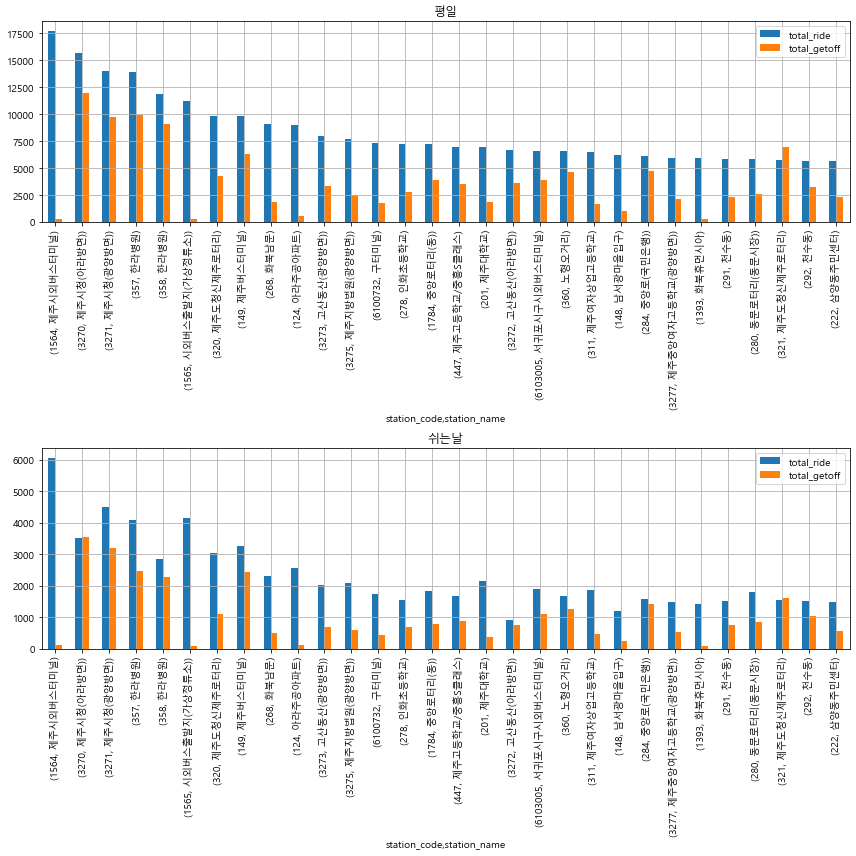

In [42]:
# (평일기준 sorting) Ride Top 30 bus_station
dayofweek_print_plot(train, idx_min=0,idx_max=30, sorting_col = 'total_ride')

**bus_bts - user_card_id별 버스 승차시간** 

In [43]:
delta_ = (bus_bts['getoff_datetime'] - bus_bts['geton_datetime'])
if delta_.dt.days.max() == 0:  
    bus_bts['travel_time'] = delta_.dt.seconds / 60 # minutes

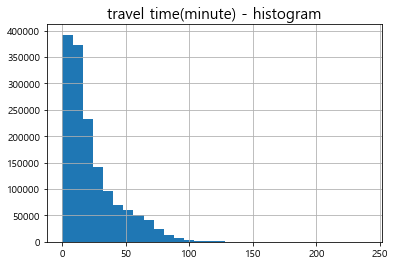

count    1513678.00
mean          23.23
std           21.54
min            0.10
25%            7.85
50%           15.85
75%           31.80
max          239.77
Name: travel_time, dtype: float64

In [44]:
plt.title("travel time(minute) - histogram", fontsize=15)
bus_bts['travel_time'].hist(bins=30)
plt.show()
round(bus_bts['travel_time'].describe(), 2)

- 대부분 승차 ~ 하차 시간은 30분 내외  
- 결측치(하차 태그 약 37% 결측) 대체에 활용해도 무방할 것으로 보임  

**시간대별, 승객유형별 승차태그 빈도수**  

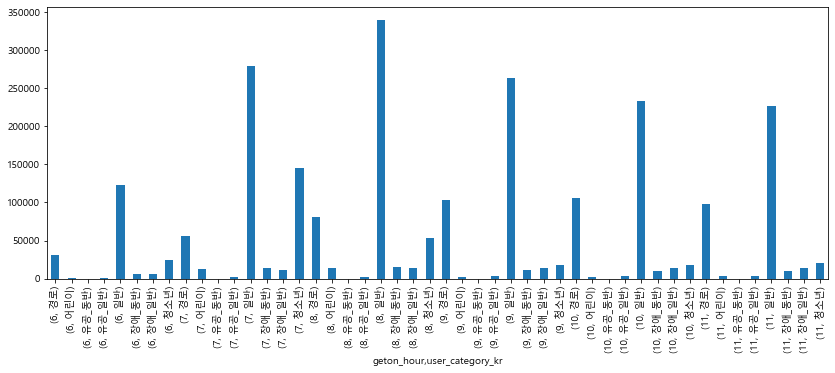

In [46]:
user_cat = {1:'일반',2:'어린이',4:'청소년',6:'경로',
            27:'장애_일반',28:'장애_동반',29:'유공_일반',30:'유공_동반'}
bus_bts['user_category_kr'] = bus_bts['user_category'].replace(user_cat)
bus_bts['geton_hour'] = bus_bts['geton_datetime'].dt.hour
bus_bts.groupby(['geton_hour', 'user_category_kr']).size().plot(kind='bar', figsize=(14,5))
plt.show()

- 청소년 : 7~8시 쯤에 많이타고(등교)  
- 경로 : 두루두루 있고  
- 별다른 이슈는 없음(평일, 쉬는날 구분해서 보기)  
- "누가" "어디서" "언제" 많이 이용하는지를 보기  

# 2. 버스정류소별 좌표정보 테이블    

In [26]:
st_col = ['station_code','station_name','in_out','longitude','latitude']
station_loc = pd.concat([train[st_col], test[st_col]], ignore_index=True).drop_duplicates().reset_index(drop=True)
station_loc[['longitude','latitude']] = station_loc[['longitude','latitude']].astype(float)
station_loc['geometry'] = station_loc.apply(lambda x : Point(x.longitude, x.latitude), axis=1)
station_loc = gpd.GeoDataFrame(station_loc, geometry='geometry', crs=epsg4326)

print("*버스 정류장 수 :", len(station_loc))
print(station_loc['in_out'].value_counts())
station_loc.head()

*버스 정류장 수 : 3601
시내    3519
시외      82
Name: in_out, dtype: int64


,station_code,station_name,in_out,longitude,latitude,geometry
0,344,제주썬호텔,시외,126.49373,33.48990,POINT (126.49373 33.4899)
1,357,한라병원,시외,126.48508,33.48944,POINT (126.48508 33.48944)
2,432,정존마을,시외,126.47352,33.48181,POINT (126.47352 33.48181)
3,1579,제주국제공항(600번),시내,126.49252,33.50577,POINT (126.49252 33.50577)
4,1646,중문관광단지입구,시내,126.41260,33.25579,POINT (126.4126 33.25579)


In [27]:
jeju_bjd = gpd.GeoDataFrame.from_file('LSMD_ADM_SECT_UMD_50.shp',encoding='cp949')
if jeju_bjd.crs is None:
    jeju_bjd.crs = epsg5179
else:
    jeju_bjd = jeju_bjd.to_crs(epsg4326)
#    jeju_bjd = jeju_bjd.explode().reset_index(drop=True)

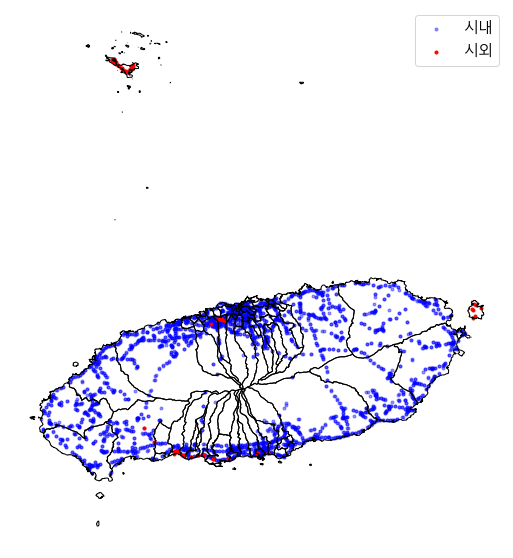

In [28]:
ax=jeju_bjd.boundary.plot(linewidth=1,color='black',figsize=(10,10))
station_loc[station_loc['in_out']=="시내"].plot(ax=ax, color='blue',markersize=9, alpha=.4, label='시내')
station_loc[station_loc['in_out']=="시외"].plot(ax=ax, color='red',markersize=9,  label='시외')
plt.legend(fontsize=15)
plt.axis('off')
plt.show()

- 시내, 시외 버스 정류장의 의미 불분명  
- 고립된 정류장과 그렇지 않은 정류장을 구분할 필요가 있음  

### 2-1 folium으로 동적 지도 생성  

In [33]:
from folium.plugins import MarkerCluster
def add_marker(map_, geo_df, cluster_op = False, c='red'):
    if cluster_op:
        marker_cluster = MarkerCluster().add_to(map_)
    for i in range(len(geo_df)):   
        marker=folium.Marker(
              location=[station_loc.geometry.y[i], station_loc.geometry.x[i]],
              popup=station_loc.station_name[i],
              icon=folium.Icon(color=c,icon='star')
            )
        if cluster_op:
            marker.add_to(marker_cluster)
        else:
            marker.add_to(map_)

In [34]:
jeju_airport = [33.50577,126.49252] # 제주공항
osm_map = folium.Map(location=jeju_airport, zoom_start=9)
add_marker(osm_map, station_loc[station_loc['in_out']=="시외"], cluster_op = True, c='blue')
osm_map

- 시외버스만 folium으로 확인해보기  

# 3. 상관관계(Correlation)  

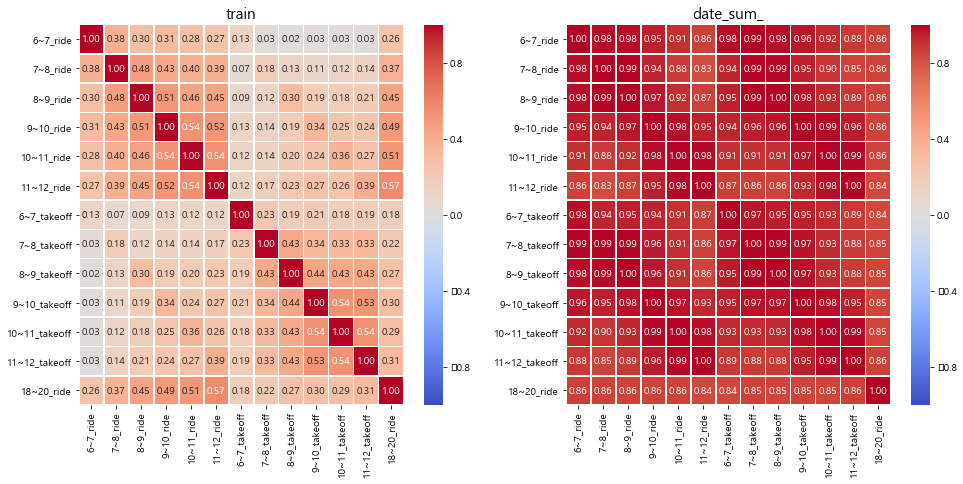

In [53]:
plt.figure(figsize=(16,7))
ax = plt.subplot(1,2,1)
plt.title("train", fontsize=15)
sns.heatmap(data = train[col_t + ["18~20_ride"]].corr(),
            annot=True,
            fmt = '.2f',
            linewidths=.5,
            cmap='coolwarm',
            vmin = -1, vmax = 1,
            ax=ax)
ax = plt.subplot(1,2,2)
plt.title("date_sum_", fontsize=15)
sns.heatmap(data = date_sum_.corr(),
            annot=True,
            fmt = '.2f',
            linewidths=.5,
            cmap='coolwarm',
            vmin = -1, vmax = 1,
            ax=ax)
plt.show()

- 데이터 자체가 일별, 시간대별, 버스노선별 승차인원 수에 대한 데이터이기 때문에 위에서 확인했던 것 처럼 대부분의 값이 0~1의 값이다.  
- 이 점을 고려해서 시간대를 통합(sum)해서 활용하거나, 노선 또는 일별의 파생변수를 생성하는 것도 중요할 것으로 보인다.  

# 정리      

**1. 파생변수**  

- 요일, 공휴일, 주말에 대한 파생변수 필요  
- 제주도는 많은 섬으로 이루어져 있으므로(특히 추자도), 고립된 정류장과 아닌 정류장을 구분할 필요가 있음  
- 노선별 정류장의 분포, 개별 user card id에 대한 OD matrix를 활용한 분석(network analysis)  
- 비대칭 데이터 처리 : 시간별 승하차 인원 수의 75%가 0~1값이며, 왜곡된 분포로 시간대별 병합 또는 스케일링이 필요함  

**2. 외부데이터 활용**  

- 기상데이터 : 비가 오는지 여부에 따른 버스이용률 차이  
- 인구통계학적 데이터 : 행정구역 단위, 실거주 인구 / 직장인구 , 연령대 등
- 개별 장소에 대한 위치정보 : 수요가 많을 것 같은 정류장(정류장 명에서 추출, 고등학교, 대학교, 환승 등등), 또는 주요 지점(like 랜드마크)과의 거리  